The point of this notebook is to build a custom dataset and sampler for the time series analysis we want to do. The idea is the following, we have a burst dataset much of which is nodata. Furthermore we want to load a series of these datasets into batches. Don't want to waste training on patches that are empty and want to make sure we can load this data in moderately performant way considering there is so much streaming and urls happening.

I am sure this will be improved and modified as time goes on and this represents a first attempt.

In [43]:
import geopandas as gpd
import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import box
from rasterio.transform import xy
import pandas as pd
from tqdm import tqdm
from rasterio.windows import Window
import concurrent.futures
from dem_stitcher.geojson_io import to_geojson_gzip, read_geojson_gzip
from rasterio.warp import transform_bounds
from tile_mate import get_raster_from_tiles
from tile_mate.stitcher import DATASET_SHORTNAMES
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
DATASET_SHORTNAMES

['pekel_water_occ_2021',
 'esa_world_cover_2020',
 'esa_world_cover_2021',
 'hansen_annual_mosaic',
 'hansen_lossyear',
 'hansen_gain',
 'hansen_treecover_2000',
 's1_coherence_2020',
 'cop_100_lulc_discrete',
 'radd_deforestation_alerts_2022',
 'hand',
 'glad_landcover',
 'glad_change']

# Burst data

In [2]:
df_rtc_meta = pd.read_parquet('rtc_s1_table.parquet')
df_rtc_meta.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
1,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
2,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
3,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
4,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


# For one burst

In [3]:
BURST_ID = 'T076-163099-IW1'#'T126-269585-IW2'

In [4]:
df_ts = df_rtc_meta[df_rtc_meta['jpl_burst_id'] == BURST_ID].reset_index(drop=True)
df_ts.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T076-163099-IW1_20201002T22582...,S1A_IW_SLC__1SDV_20201002T225827_20201002T2258...,T076-163099-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-02 22:58:27
1,OPERA_L2_RTC-S1_T076-163099-IW1_20201014T22582...,S1A_IW_SLC__1SDV_20201014T225827_20201014T2258...,T076-163099-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-14 22:58:27
2,OPERA_L2_RTC-S1_T076-163099-IW1_20201026T22582...,S1A_IW_SLC__1SDV_20201026T225827_20201026T2258...,T076-163099-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-26 22:58:27
3,OPERA_L2_RTC-S1_T076-163099-IW1_20201107T22582...,S1A_IW_SLC__1SDV_20201107T225827_20201107T2258...,T076-163099-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-07 22:58:27
4,OPERA_L2_RTC-S1_T076-163099-IW1_20201119T22582...,S1A_IW_SLC__1SDV_20201119T225827_20201119T2258...,T076-163099-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-19 22:58:27


In [5]:
sample_paths = [p for p in df_ts.rtc_s1_vv_url]
sample_paths[0]

'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/RTC_S1/OPERA_L2_RTC-S1_T076-163099-IW1_20201002T225827Z_20240426T175120Z_S1A_30_v1.0/OPERA_L2_RTC-S1_T076-163099-IW1_20201002T225827Z_20240426T175120Z_S1A_30_v1.0_VV.tif'

In [32]:
with rasterio.open(sample_paths[0]) as ds:
    data_mask = ds.read_masks(1).astype(bool)
    width = ds.width
    height = ds.height
    X = ds.read(1)
    transform = ds.transform
    p = ds.profile
    bounds_utm = ds.bounds
p['crs']

CRS.from_epsg(32719)

In [7]:
p['crs'].to_epsg()

32719

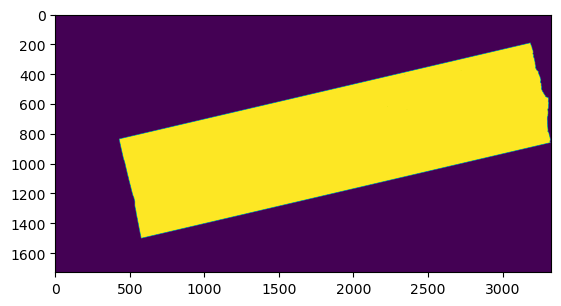

In [8]:
plt.imshow(data_mask)

In [38]:
bounds_ll = transform_bounds(p['crs'], CRS.from_epsg(4326), *bounds_utm)

In [40]:
X_glad_lc, p_lc = get_raster_from_tiles(bounds_ll, tile_shortname='glad_landcover', year=2020)

Reading tile imagery: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


In [46]:
X_glad_lc_utm, p_lc_r = reproject_arr_to_match_profile(X_glad_lc, p_lc, p)
X_glad_lc_utm = X_glad_lc_utm[0, ...]

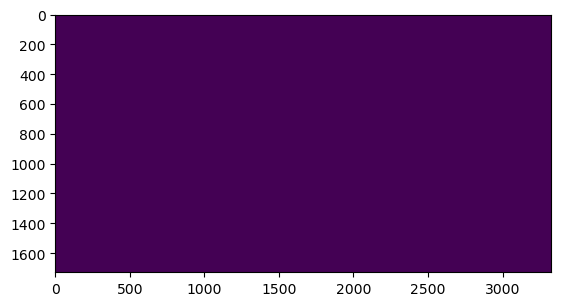

In [48]:
plt.imshow(X_glad_lc_utm == 254)

In [9]:
stride = 100
patch_x = 224
patch_y = 224
percent_covered = .9  # as value in [0, 1]
pixels_covered = patch_x * patch_y * percent_covered
pixels_covered

45158.4

In [10]:
n_x = width // stride + 1
n_y = height // stride + 1

In [11]:
slices_x = [np.s_[i * stride: i * stride + patch_x] for i in range(n_x)]
slices_y = [np.s_[i * stride: i * stride + patch_x] for i in range(n_y)]

In [12]:
patches = [(sy, sx) for sy in slices_y for sx in slices_x]
len(patches)

612

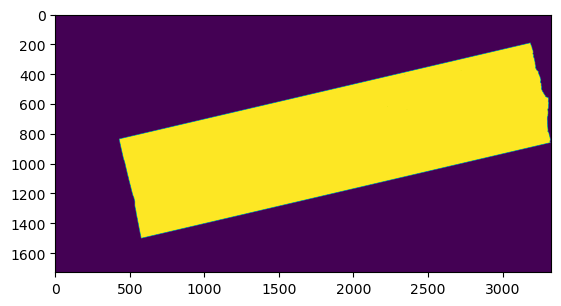

In [49]:
data_mask_f = (data_mask.astype(bool) & ~(X_glad_lc_utm == 254))
plt.imshow(data_mask_f)

In [13]:
data_mask.shape

(1729, 3327)

In [52]:
patches_with_data = [p for p in patches 
                     if (data_mask_f[p].sum() > pixels_covered) 
                     and (data_mask_f[p].shape == (patch_x, patch_y))
                    ]
len(patches_with_data)

134

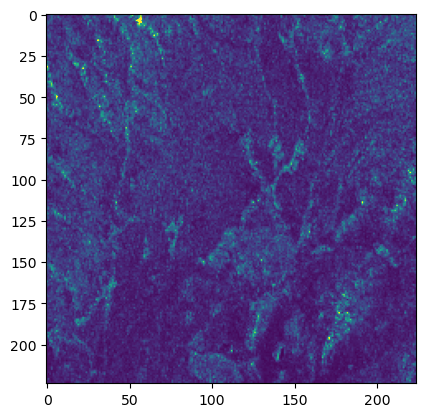

In [53]:
plt.imshow(X[patches_with_data[50]], vmin=0, vmax=.5)

In [16]:
patches_with_data[100]

(slice(900, 1124, None), slice(1300, 1524, None))

In [17]:
def get_geo(sx, sy, transform):
    xmin, ymin = xy(transform, sy.start, sx.start)
    xmax, ymax = xy(transform, sy.stop, sx.stop)
    return box(xmin, ymin, xmax, ymax)

patch_records = [{'x_start': sx.start,
                  'x_stop': sx.stop,
                  'y_start': sy.start,
                  'y_stop': sy.stop,
                  'epsg': p['crs'].to_epsg(),
                  'burst_id': 'T064_135524_IW1',
                  'geometry': get_geo(sx, sy, transform)} for (sy, sx) in tqdm(patches_with_data)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 12384.57it/s]


In [18]:
patch_records[0]

{'x_start': 2600,
 'x_stop': 2824,
 'y_start': 300,
 'y_stop': 524,
 'epsg': 32719,
 'burst_id': 'T064_135524_IW1',
 'geometry': <POLYGON ((761685 7462665, 761685 7455945, 754965 7455945, 754965 7462665, 7...>}

<Axes: >

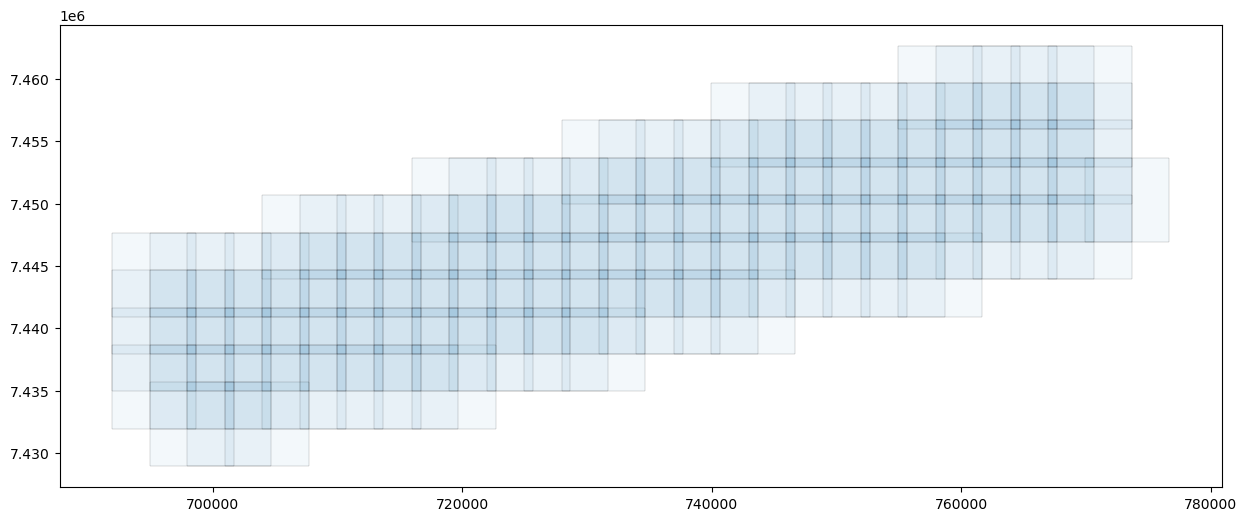

In [19]:
df_patches = gpd.GeoDataFrame(patch_records)
df_patches['patch_id'] = df_patches.index
ax = df_patches.exterior.plot(figsize=(15, 10), color='black', lw=.1, alpha=1)
df_patches.plot(figsize=(15, 10), alpha=.05, ax=ax)


# Serializing all the Bursts

In [54]:
burst_ids = df_rtc_meta.jpl_burst_id.unique()

def get_utm_geo(sx, sy, transform):
    xmin, ymin = xy(transform, sy.start, sx.start)
    xmax, ymax = xy(transform, sy.stop, sx.stop)
    return box(xmin, ymin, xmax, ymax)

def get_patch_dataframe_utm(burst_id: str, 
                            stride = stride,
                            patch_x = patch_x,
                            patch_y = patch_y,
                            percent_covered = percent_covered,
                            serialize=False,
                            burst_patch_dir = Path('burst_patch_data_v2')) -> gpd.GeoDataFrame:
        
    burst_patch_dir = Path(burst_patch_dir)
    burst_patch_dir.mkdir(exist_ok=True, parents=True)

    out_path = burst_patch_dir / f'{burst_id}.json'

    if out_path.exists() and serialize:
       return out_path
    
    pixels_covered_per_patch = patch_x * patch_y * percent_covered
    df_ts = pd.read_parquet('rtc_s1_table.parquet',
                              filters=[('jpl_burst_id', '=', burst_id)])
    path_vv = df_ts.rtc_s1_vv_url[0]
    
    with rasterio.open(path_vv) as ds:
        data_mask = ds.read_masks(1).astype(bool)
        width = ds.width
        height = ds.height
        transform = ds.transform
        p = ds.profile
        bounds_utm = ds.bounds
        
    bounds_ll = transform_bounds(p['crs'], CRS.from_epsg(4326), *bounds_utm)
    X_glad_lc, p_lc = get_raster_from_tiles(bounds_ll, tile_shortname='glad_landcover', year=2020)

    X_glad_lc_utm, p_lc_r = reproject_arr_to_match_profile(X_glad_lc, p_lc, p)
    X_glad_lc_utm = X_glad_lc_utm[0, ...]

    data_mask_f = (data_mask.astype(bool) & ~(X_glad_lc_utm == 254)).astype(np.uint8)
    
    n_x = width // stride + 1
    n_y = height // stride + 1
    
    slices_x = [np.s_[i * stride: i * stride + patch_x] for i in range(n_x)]
    slices_y = [np.s_[i * stride: i * stride + patch_x] for i in range(n_y)]

    patches = [(sy, sx) for sy in slices_y for sx in slices_x]
    patches_with_data = [p for p in patches if (data_mask_f[p].sum() > pixels_covered)
                         and (data_mask_f[p].shape == (patch_x, patch_y))]

    patch_records = [{'x_start': sx.start,
                      #'x_stop': sx.stop,
                      'y_start': sy.start,
                      #'y_stop': sy.stop,
                      #'epsg': p['crs'].to_epsg(),
                      'jpl_burst_id': burst_id,
                      #'geometry': get_geo(sx, sy, transform)
                     } for (sy, sx) in patches_with_data]

    #df = gpd.GeoDataFrame.from_dict(patch_records, crs=p['crs'])
    df = pd.DataFrame(patch_records)
    if not serialize:
        return df
    else:
        df.to_json(out_path)
        return out_path
        

In [ ]:
from mpire import WorkerPool


with WorkerPool(n_jobs=20, use_dill=True) as pool:
    dfs = pool.map(
        get_patch_dataframe_utm, (bid for bid in burst_ids), 
        progress_bar=True, 
        progress_bar_style='notebook', 
        iterable_len=len(burst_ids)
    )

  0%|                                                                                                         …

Reading tile metadata: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.14it/s]
/u/duvel-d2/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-packages/dem_stitcher/rio_window.py:99: RuntimeWarning: Requesting extent beyond raster bounds of [-10.0, 40.0, 0.0, 50.0]. Shrinking bounds in raster crs to (-0.3581519324233727, 41.808556237681614, 0.0, 42.246516764996706).
  warn(
Reading tile imagery:   0%|                                                                                                              | 0/1 [00:00<?, ?it/s]/u/duvel-d2/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-packages/dem_stitcher/rio_window.py:99: RuntimeWarning: Requesting extent beyond raster bounds of [-10.0, 40.0, 0.0, 50.0]. Shrinking bounds in raster crs to (-0.31796185570665786, 41.97403599609201, 0.0, 42.412255685419275).
  warn(
Reading tile metadata:   0%|                                                       

In [57]:
df_patch = pd.concat(dfs, axis=0)
df_patch.to_parquet('burst_patch_table.parquet')

## Checking we can stream data using our dataframe

In [61]:
all_burst_ids = df_rtc_meta.jpl_burst_id.unique()
df_patches = pd.read_parquet('burst_patch_table.parquet',
                              filters=[('jpl_burst_id', '=', all_burst_ids[30])])

In [62]:

utm_record = df_patches.iloc[40].to_dict()
ind = (df_rtc_meta['jpl_burst_id'] == utm_record['jpl_burst_id'])
df_ts = df_rtc_meta[ind].reset_index(drop=True)

In [63]:
PATCH_IND = 30
RASTER_IND = 30

PATH_SIZE = 224

r = utm_record
rows = [r['y_start'], r['y_start'] + PATH_SIZE]
cols = [r['x_start'], r['x_start'] + PATH_SIZE]
window = Window.from_slices(rows=rows, cols=cols)

with rasterio.open(df_ts.rtc_s1_vh_url[RASTER_IND]) as ds:
    X_p = ds.read(1, window=window)

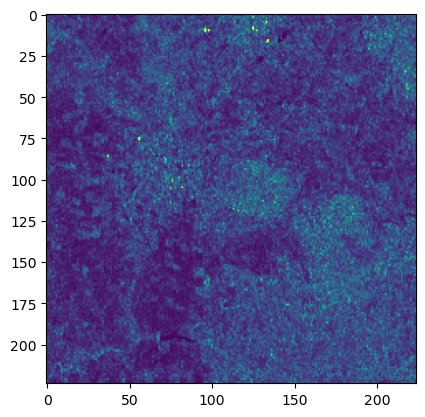

In [64]:
plt.imshow(X_p, vmin=0, vmax=.15)